In [1]:
import torch 
import matplotlib.pyplot as plt
from markov_chain_monte_carlo import *
from IPython.display import clear_output
from utils import * 
from conditional_density_estimation import * 
from misc import * 

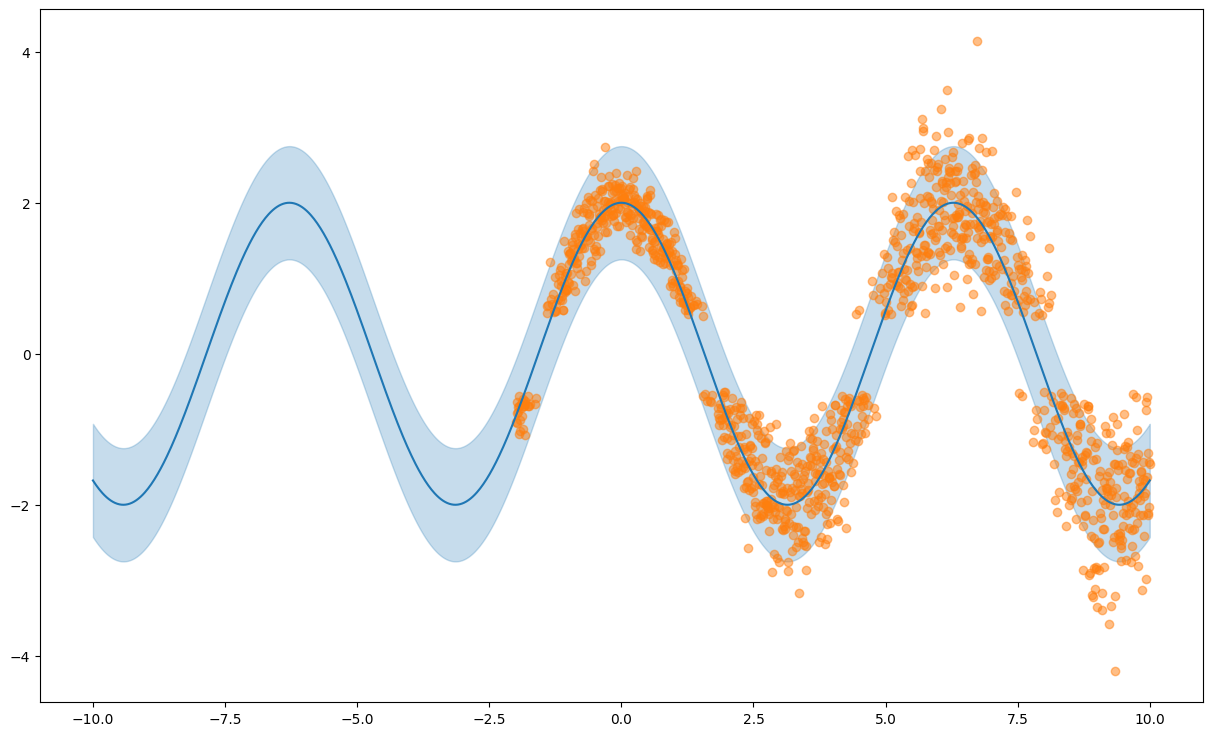

In [3]:
plt.figure(figsize = (15,9))
tt = torch.linspace(-10, 10,1000)
sigma=0.25
plt.plot(tt, 2*torch.cos(tt), color = 'C0')
plt.fill_between(tt,  2*torch.cos(tt) - 3*sigma,  2*torch.cos(tt) + 3*sigma, color = 'C0', alpha = .25)
D_x = torch.cat([torch.linspace(-10,-2,1000),torch.linspace(-2,2,500),torch.linspace(2,10,1000)])
D_y = 2*torch.cos(D_x) + sigma * torch.randn_like(D_x) * torch.sqrt(D_x)
D_y[torch.abs(D_x)<2] =  2*torch.cos(D_x[torch.abs(D_x)<2]) + sigma * torch.randn_like(D_x[torch.abs(D_x)<2])
mask = torch.abs(D_y)>0.5
D_x = D_x[mask]
D_y = D_y[mask]
plt.scatter(D_x, D_y, color = 'C1', alpha = .5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:26<00:00,  2.32it/s, loss = 1.449529 ; device: cpu]


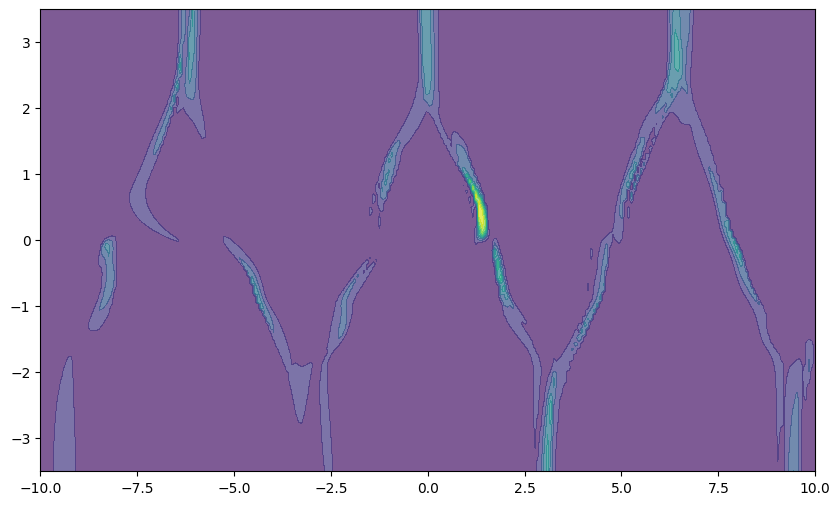

In [26]:
models = []
for _ in range(1):
    discriminative_model = ConditionalDIF(D_x.unsqueeze(-1),D_y.unsqueeze(-1),10,[128,128,128])
    discriminative_model.initialize_with_EM(100, verbose = True)
    discriminative_model.train(200,lr = 5e-3, verbose = True)
    discriminative_model.train(200,lr = 5e-4, verbose = True)
    discriminative_model.train(200,lr = 5e-5, verbose = True)
    models.append(discriminative_model)
plot_likelihood_function(lambda x,y:torch.mean(torch.cat([model.log_prob(y,x).unsqueeze(-1) for model in models], dim = -1), dim = -1), range = ((-10,10), (-3.5,3.5)), bins = (250,250), levels = 10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 143.39it/s, acceptance = tensor(0.2653)]


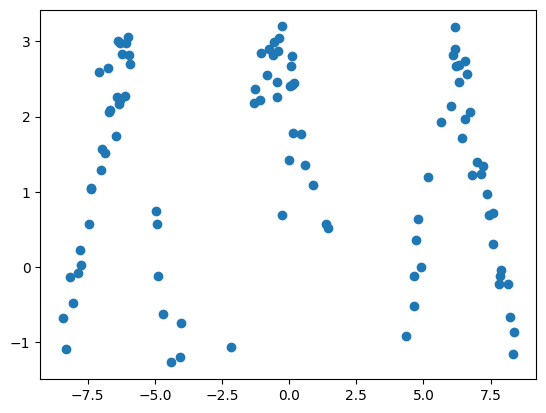

In [5]:
x_0 = torch.linspace(-3,3,100)
y_0 = (3*torch.cos(x_0[torch.abs(x_0)<2]) + 0.125 * torch.randn_like(x_0[torch.abs(x_0)<2])).unsqueeze(-1)
proposal = Uniform(torch.tensor([-10]), torch.tensor([10]))
sampler = RandomWalkMetropolisHastingsMultipleObs(discriminative_model.log_prob, y_0,1,1., proposal)
samples = sampler.sample(500,verbose = True)
plt.scatter(samples, y_0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s, loss = -0.049479 ; device: cpu]


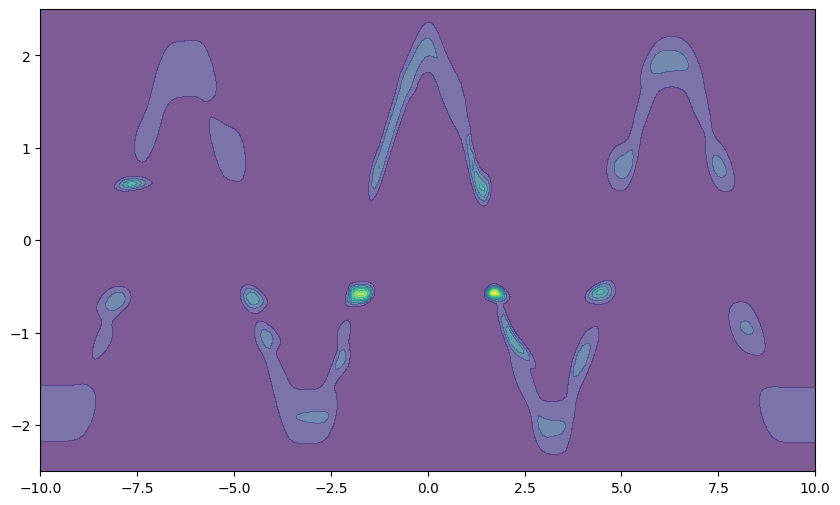

In [27]:
generative_model = ConditionalDIF(D_y.unsqueeze(-1),D_x.unsqueeze(-1),10,[128,128,128])
generative_model.initialize_with_EM(50, verbose = True)
generative_model.train(100,500,lr = 5e-3, verbose = True)
generative_model.train(100,500,lr = 5e-4, verbose = True)
generative_model.train(100,500,lr = 5e-5, verbose = True)
plot_likelihood_function(generative_model.log_prob, range = ((-10,10), (-2.5,2.5)), bins = (200,200), levels = 10)

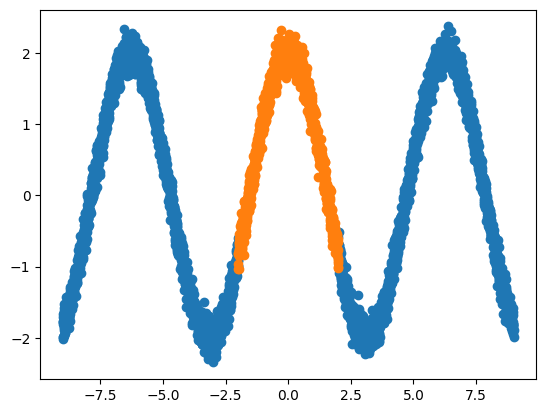

In [12]:
window = 2
mask = torch.abs(D_x)>window
x0 = D_x[~mask]
y0 = D_y[~mask]
D_x = D_x[mask]
D_y = D_y[mask]
plt.scatter(D_x, D_y)
plt.scatter(x0, y0)

In [20]:
discriminative_model = ConditionalDIF(D_x.unsqueeze(-1),D_y.unsqueeze(-1),10,[128,128,128])
discriminative_model.initialize_with_EM(50, verbose = True)
discriminative_model.train(100,500,lr = 5e-3, verbose = True)
discriminative_model.train(100,500,lr = 5e-4, verbose = True)
discriminative_model.train(100,500,lr = 5e-5, verbose = True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s, loss = 1.593317 ; device: cpu]


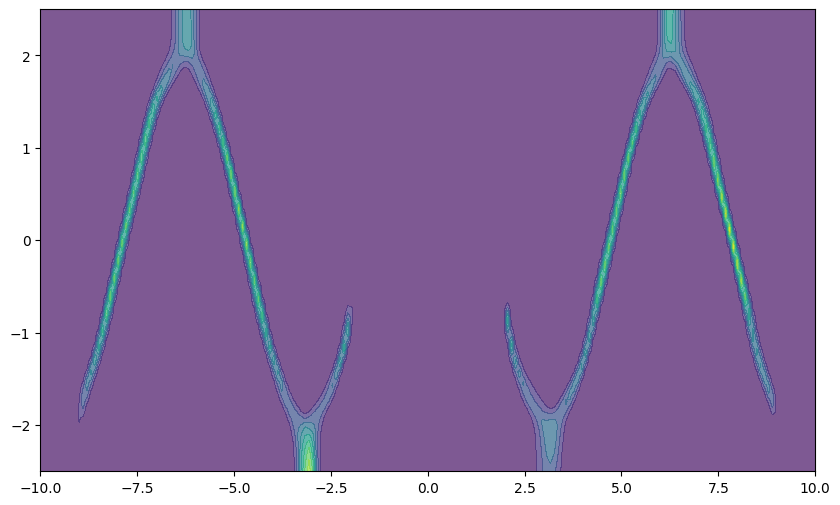

In [14]:
plot_likelihood_function(lambda x,y:discriminative_model.log_prob(y,x), range = ((-10,10), (-2.5,2.5)), bins = (200,200), levels = 10)

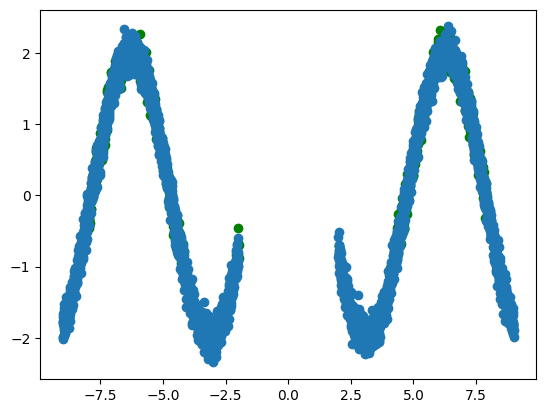

In [21]:
log_posterior =lambda x: discriminative_model.log_prob(x,y0.unsqueeze(-1))
sampler = IndependentMetropolisHastings_multiple_obs(log_posterior,1, y0.shape[0], Uniform(torch.tensor([-8]), torch.tensor([8])))
samples = sampler.sample(100, verbose = True)
clear_output(wait = True)
plt.scatter(samples, y0, color = 'green')
plt.scatter(D_x, D_y)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.98it/s, loss = -0.398134 ; device: cuda]


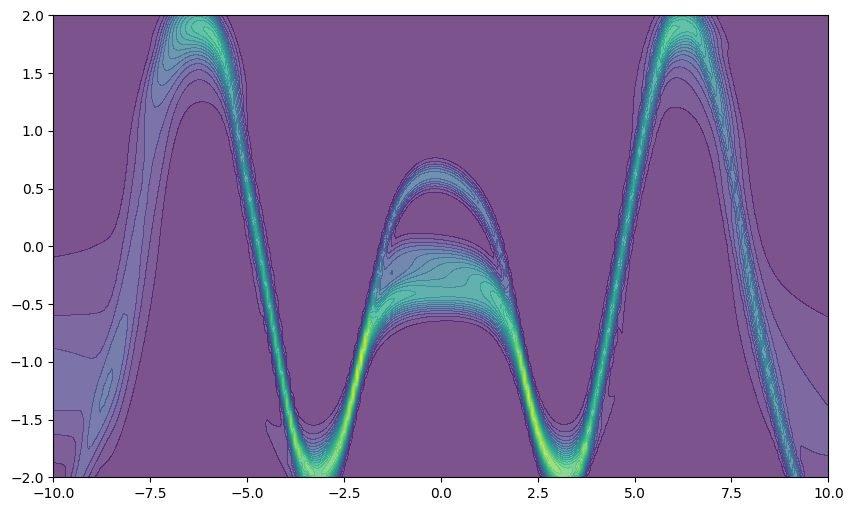

In [27]:
prior = Uniform(torch.tensor([-window]), torch.tensor([window]))

total_samples = []
total_models = []
for _ in range(5):
    generative_model = ConditionalDIF(D_y.unsqueeze(-1),D_x.unsqueeze(-1),3,[32,32,32])
    generative_model.initialize_with_EM(50)
    generative_model.train(100,500,lr = 5e-3, verbose = True)
    generative_model.train(100,500,lr = 5e-4, verbose = True)
    generative_model.train(100,500,lr = 5e-5, verbose = True)
    total_models.append(generative_model)
def plot_average_likelihood_function(log_likelihood_list, range = [[-10,10],[-10,10]], bins = [50,50], levels = 2 , alpha = 0.7, figsize = (10,6), show = True):
    total_log_likelihood = lambda y, x: torch.logsumexp(
        torch.cat([log_likelihood(y, x).unsqueeze(0) for log_likelihood in log_likelihood_list], dim=0), dim=0)
    plot_likelihood_function(total_log_likelihood, range=range, bins = bins, levels = levels, alpha = alpha, figsize = figsize, show = show)

plot_average_likelihood_function([model.log_prob for model in total_models], range = ((-10,10), (-2,2)), bins= (200,200), levels = 20)

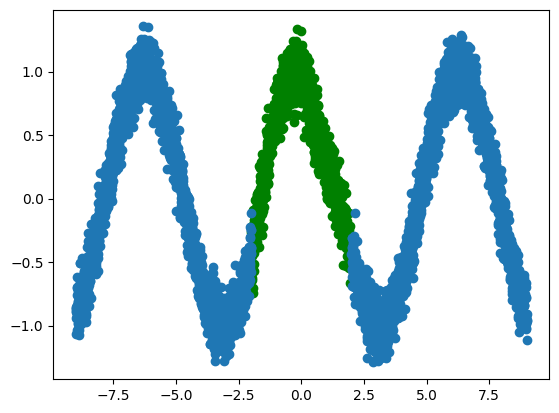

 16%|███████████████████████████████████████                                                                                                                                                                                                             | 16/100 [00:02<00:15,  5.46it/s, loss = 0.196162 ; device: cuda]


KeyboardInterrupt: 

In [28]:
from targets import *
window = 2
D_x = torch.linspace(-9,9,5000)
D_y = torch.cos(D_x) + 0.125 * torch.randn_like(D_x)
mask = torch.abs(D_x)>window
x0 = D_x[~mask].unsqueeze(-1)
y0 = D_y[~mask].unsqueeze(-1)
D_x = D_x[mask].unsqueeze(-1)
D_y = D_y[mask].unsqueeze(-1)
plt.scatter(D_x, D_y)
plt.scatter(x0, y0)
total_samples = []
total_models = []
D_y_plus = D_y
D_x_plus = D_x
for _ in range(50):
    generative_model = ConditionalDIF(D_y_plus,D_x_plus,3,[32,32,32])
    generative_model.initialize_with_EM(50)
    generative_model.train(100,500,lr = 5e-3, verbose = True)
    generative_model.train(100,500,lr = 5e-4, verbose = True)
    generative_model.train(100,500,lr = 5e-5, verbose = True)

    joint_log_posterior =lambda x: generative_model.log_prob(y0, x)+ prior.log_prob(x)
    sampler = IndependentMetropolisHastings_multiple_obs(joint_log_posterior,1, y0.shape[0], prior)
    samples = sampler.sample(100, verbose = True)
    clear_output(wait = True)
    plt.scatter(samples, y0, color = 'green')
    plt.scatter(D_x, D_y)
    plt.show()
    D_x_plus = torch.cat([D_x, samples], dim=0)
    D_y_plus = torch.cat([D_y, y0], dim = 0)
    total_samples.append(samples)
    total_models.append(generative_model)

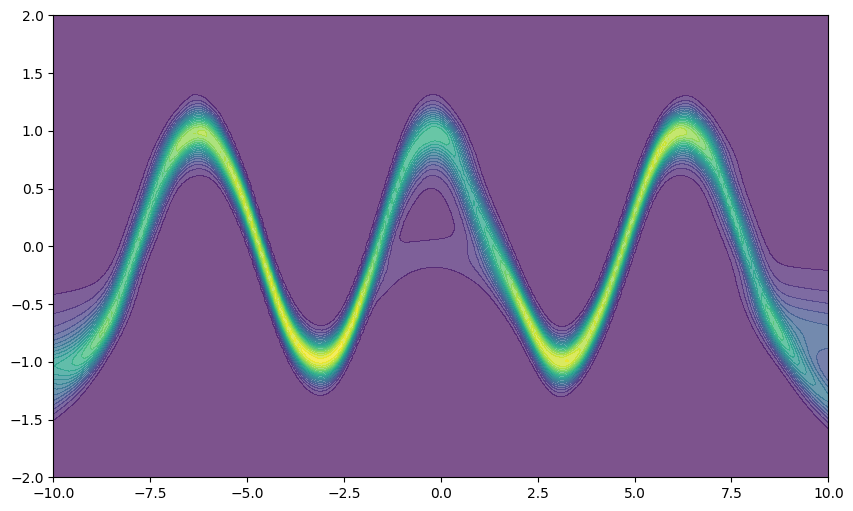

In [29]:
def plot_average_likelihood_function(log_likelihood_list, range = [[-10,10],[-10,10]], bins = [50,50], levels = 2 , alpha = 0.7, figsize = (10,6), show = True):
    total_log_likelihood = lambda y, x: torch.logsumexp(
        torch.cat([log_likelihood(y, x).unsqueeze(0) for log_likelihood in log_likelihood_list], dim=0), dim=0)
    plot_likelihood_function(total_log_likelihood, range=range, bins = bins, levels = levels, alpha = alpha, figsize = figsize, show = show)

plot_average_likelihood_function([model.log_prob for model in total_models], range = ((-10,10), (-2,2)), bins= (200,200), levels = 20)